In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import joblib

In [2]:
np.random.seed(13)
rng = np.random

In [3]:
# --------------------
# Config
# --------------------
n_users = 300
n_artists = 30
n_tracks_avg = 16
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 3, 31)
artist_weighting = 0.5
track_weighting = 0.7
weekend_effect=1.1
#short_session_prob=0.15
#short_session_choices=(1,2,3)
#lognorm_mu=1.0           
#lognorm_sigma=0.9
avg_inter_track_sec=210
std_inter_track_sec=45

In [4]:
# --------------------
# Artist + Track metadata
# --------------------
artist_ids = [f"artist_{i+1}" for i in range(n_artists)]
tracks = []

ranks = np.arange(1, n_artists + 1)
artist_weights = 1 / ranks ** artist_weighting
artist_weights = artist_weights / artist_weights.sum()

for a_idx, aid in enumerate(artist_ids):
    n_tracks = np.random.randint(1/2*n_tracks_avg, 2*n_tracks_avg)
    ranks = np.arange(1, n_tracks + 1)
    weighting = rng.uniform(0,track_weighting)
    track_weights = 1 / ranks ** weighting
    track_weights = track_weights / track_weights.sum()
    for t in range(n_tracks):
        t_len = np.random.normal(loc=avg_inter_track_sec, 
                                 scale=std_inter_track_sec)
        tracks.append({
            "artist_id": aid, 
            "track_id": f"{aid}_track_{t+1}", 
            "track_len_sec":t_len,
            "artist_popularity": artist_weights[a_idx],
            "track_popularity": track_weights[t],
            "total_track_popularity": artist_weights[a_idx] * track_weights[t]
                      })
tracks_df = pd.DataFrame(tracks)



In [5]:
tracks_df.head()

,artist_id,track_id,track_len_sec,artist_popularity,track_popularity,total_track_popularity
0,artist_1,artist_1_track_1,234.836382,0.104328,0.097664,0.010189
1,artist_1,artist_1_track_2,179.183451,0.104328,0.072737,0.007589
2,artist_1,artist_1_track_3,237.418483,0.104328,0.061220,0.006387
3,artist_1,artist_1_track_4,274.281367,0.104328,0.054172,0.005652
4,artist_1,artist_1_track_5,188.201603,0.104328,0.049269,0.005140


In [6]:
# --------------------
# User metadata
# --------------------
mixed_sesh_pct = 0.5 # are they less mixed < 0.5 = single artists
popular_music_fan = 0.5 # are they more into popular artists > 0.5 or even mix
songs_per_sesh_mu = 6.
sesh_per_day_mu = 1.2
mixed_sesh_time = 0.5 # are they a random sesh < 0.5 or ordered sesh i.e. morning
skip_prob = 0.1 # lower means less chance of skipping songs
skip_max = 0.3

users = []
for user_id in range(1, n_users + 1):
    users.append(
        {"user_id": user_id,
        "mix_sesh": rng.uniform(),
        "pop_fan": rng.uniform(),
        "sesh_len": np.clip(rng.poisson(songs_per_sesh_mu), 1, 10000),
        "sesh_num": np.clip(rng.poisson(sesh_per_day_mu), 1, 10000),
        "skip_prob": np.clip(rng.normal(skip_prob,skip_prob/2),0.005,skip_max)}
    )
users_df = pd.DataFrame(users)

In [7]:
users_df.head()

,user_id,mix_sesh,pop_fan,sesh_len,sesh_num,skip_prob
0,1,0.770236,0.449934,7,1,0.164454
1,2,0.678292,0.198552,7,1,0.060115
2,3,0.578218,0.631687,3,1,0.116786
3,4,0.018463,0.583200,8,2,0.164076
4,5,0.839165,0.622390,5,1,0.071558


In [8]:
# --------------------
# Stream Generation
# --------------------
date_range = pd.date_range(start_date, end_date, freq="D")
streams = []

currrent_sesh = 0
for user_id in users_df['user_id']:

    temp_user_df = users_df[users_df['user_id'] == user_id].iloc[0]

    for day in date_range:
        
        day_factor = weekend_effect if day.weekday() >= 5 else 1.0
        n_sessions = rng.poisson(temp_user_df['sesh_num'] * day_factor)

        if n_sessions == 0:
            continue

        for sesh_i in range(n_sessions):
            n_streams = np.clip(rng.poisson(temp_user_df['sesh_len'] * day_factor), 1, 10000)

            session_start = pd.Timestamp(
                year=day.year, month=day.month, day=day.day,
                hour=rng.randint(0, 24),
                minute=rng.randint(0, 60),
                second = rng.randint(0, 60)
            )

            ts = session_start

            if rng.random() < temp_user_df['mix_sesh']:
                # Mixed session: all tracks are weighted by track popularity
                session_tracks = tracks_df.sample(
                    n=n_streams,
                    replace=True,
                    weights=tracks_df['total_track_popularity']
                )
            else:
                # Focused session: pick one artist, then sample from their tracks
                artist_choice = tracks_df['artist_id'].sample(
                    n=1,
                    weights=tracks_df['artist_popularity']
                ).iloc[0]
                
                session_tracks = tracks_df.query(
                    "artist_id == @artist_choice"
                ).sample(
                    n=n_streams,
                    replace=True
                )

            for _, track in session_tracks.iterrows():
                
                track_len = track['track_len_sec']
                if np.random.rand() < temp_user_df['skip_prob']:
                    skip_fraction = np.random.uniform(0.01, 0.9)  
                    listen_time = track_len * skip_fraction
                else:
                    listen_time = track_len

                streams.append({
                    "user_id": user_id,
                    "session_id": currrent_sesh,
                    "timestamp": ts,
                    "artist_id": track['artist_id'],
                    "track_id": track['track_id'],
                    "track_duration_sec": track_len,
                    "listen_duration_sec": listen_time,
                    "is_bot": False
                })

                ts += pd.Timedelta(seconds=listen_time)
            currrent_sesh+=1

In [9]:
streams_df = pd.DataFrame(streams)

In [10]:
streams_df.head()

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
0,1,0,2025-01-01 11:33:51.000000000,artist_5,artist_5_track_4,221.135215,221.135215,False
1,1,0,2025-01-01 11:37:32.135215366,artist_5,artist_5_track_24,143.815144,143.815144,False
2,1,0,2025-01-01 11:39:55.950359048,artist_5,artist_5_track_25,186.771027,186.771027,False
3,1,0,2025-01-01 11:43:02.721386533,artist_5,artist_5_track_11,273.485836,67.818156,False
4,1,0,2025-01-01 11:44:10.539542678,artist_5,artist_5_track_6,139.508736,139.508736,False


In [11]:
streams_df.sort_values(['timestamp'])

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
11356,15,1822,2025-01-01 00:02:50.000000000,artist_2,artist_2_track_5,232.946962,232.946962,False
11357,15,1822,2025-01-01 00:06:42.946962349,artist_2,artist_2_track_13,218.786526,218.786526,False
109970,127,17723,2025-01-01 00:09:13.000000000,artist_24,artist_24_track_13,203.193053,203.193053,False
227611,251,35249,2025-01-01 00:09:30.000000000,artist_11,artist_11_track_4,143.316494,143.316494,False
16838,18,2450,2025-01-01 00:09:31.000000000,artist_8,artist_8_track_10,177.118880,177.118880,False
...,...,...,...,...,...,...,...,...
229058,252,35550,2025-03-31 23:55:52.722754356,artist_10,artist_10_track_7,210.809196,210.809196,False
45012,50,6837,2025-03-31 23:58:21.000000000,artist_7,artist_7_track_2,256.500693,88.350759,False
209924,237,32764,2025-03-31 23:59:20.093968822,artist_7,artist_7_track_1,157.771644,157.771644,False
45013,50,6837,2025-03-31 23:59:49.350758826,artist_7,artist_7_track_5,163.879492,163.879492,False


In [141]:
streams_df.tail()

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
271135,300,42217,2025-03-29 10:46:58.942234358,artist_1,artist_1_track_17,212.782937,212.782937,False
271136,300,42217,2025-03-29 10:50:31.725171576,artist_16,artist_16_track_26,199.450335,199.450335,False
271137,300,42217,2025-03-29 10:53:51.175507067,artist_3,artist_3_track_2,274.881047,274.881047,False
271138,300,42217,2025-03-29 10:58:26.056553828,artist_26,artist_26_track_17,185.744634,45.057898,False
271139,300,42217,2025-03-29 10:59:11.114451851,artist_5,artist_5_track_8,317.337363,317.337363,False


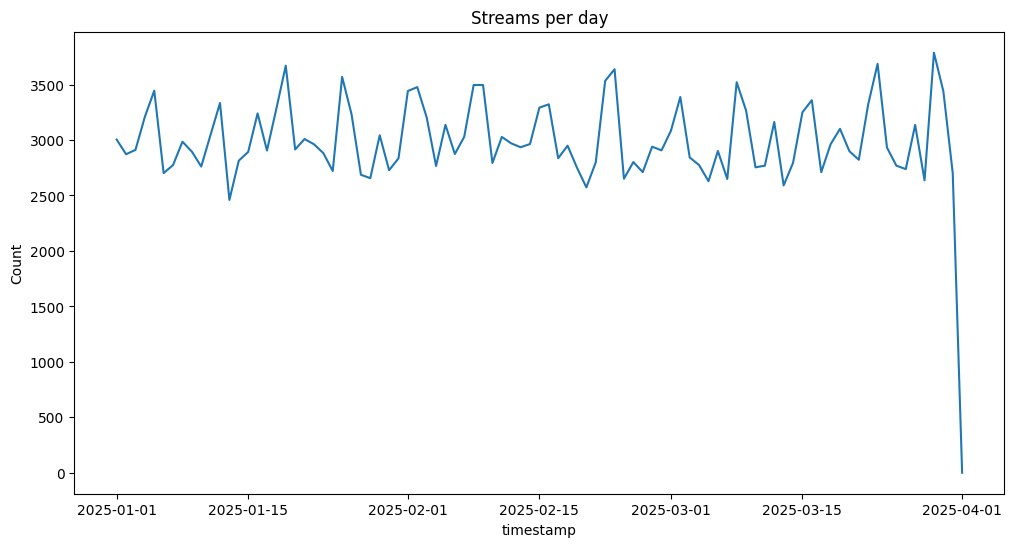

In [12]:
vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

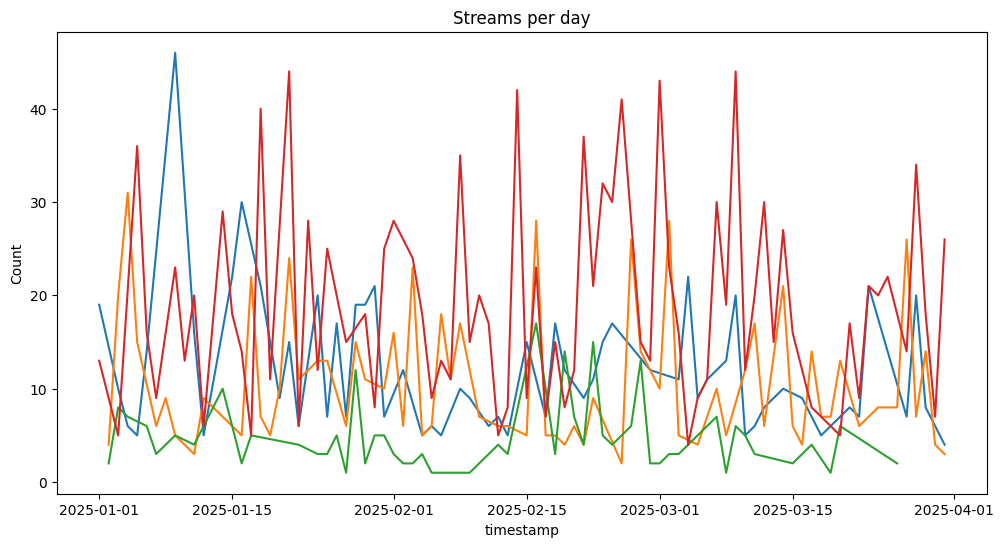

In [13]:
vc = (streams_df[streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==3])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['user_id']==4])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [14]:
def inject_long_session_bot(streams_df, user_id, start_time, duration_hours=5, artist_id=None):

    max_sess = streams_df['session_id'].max() if 'session_id' in streams_df.columns else 0
    new_session_id = max_sess + 1

    if artist_id is None:
        artist_id = streams_df['artist_id'].sample(1).iloc[0]
    track_length_sec = avg_inter_track_sec

    n_streams = int(duration_hours * 3600 / track_length_sec)
    timestamps = [start_time + pd.Timedelta(seconds=i*track_length_sec) for i in range(n_streams)]

    tracks_sampled = tracks_df[tracks_df['artist_id'] == artist_id].sample( \
            n=n_streams, replace=True)

    bot_streams = pd.DataFrame({
        'user_id': [user_id] * n_streams,
        'session_id': [new_session_id] * n_streams,
        'timestamp': timestamps,
        'artist_id': [artist_id] * n_streams,
        'track_id': tracks_sampled['track_id'],
        'track_duration_sec': tracks_sampled['track_len_sec'],
        'listen_duration_sec':  tracks_sampled['track_len_sec'],
        'is_bot': True
    })

    return pd.concat([streams_df, bot_streams], ignore_index=True)

In [15]:
def inject_bot_sessions(streams_df, n_bots, n_sessions, bot_fn, start_time, duration_hours, wait_hours, artist_id=None):
    
    bot_user_ids = [streams_df['user_id'].max() + 1 + i for i in range(n_bots)]
    durations = [duration_hours* 2*(i+1)/n_bots for i in range(n_bots)]
    waits = [wait_hours* 2*(i+1)/n_bots for i in range(n_bots)]
    
    split_points = sorted([rng.randint(0, n_sessions) for _ in range(n_bots - 1)])
    split_points.insert(0, 0)
    split_points.append(n_sessions)
    sessions_per_bot = [split_points[i+1] - split_points[i] for i in range(n_bots)]

    timestamps = [[start_time + pd.Timedelta(days=j) + pd.Timedelta(hours=i*durations[j]) + \
                  pd.Timedelta(hours=i*waits[j]) for i in range(sessions_per_bot[j])] \
                    for j in range(n_bots)]
    temp_df = streams_df
    for i in range(len(bot_user_ids)):
        for timestamp in timestamps[i]:
            temp_df = bot_fn(temp_df, bot_user_ids[i], timestamp, durations[i], artist_id)

    return temp_df

In [16]:
def inject_bot_sessions(streams_df, n_bots, n_sessions, bot_fn, start_time, 
                        campaign_days, session_hours, bottiness, artist_id=None):
    
    split_points = sorted(rng.choice(range(1, n_sessions), size=n_bots-1, replace=False))
    split_points = [0] + split_points + [n_sessions]
    sessions_per_bot = [split_points[i+1] - split_points[i] for i in range(n_bots)]

    bot_user_ids = [streams_df['user_id'].max() + 1 + i for i in range(n_bots)]
    temp_df = streams_df.copy()

    for b, bot_id in enumerate(bot_user_ids):

        base_times = pd.date_range(
            start=start_time,
            periods=sessions_per_bot[b],
            end=start_time + pd.Timedelta(days=campaign_days)
        )

        if bottiness > 0:
            
            spacing = (campaign_days * 24) / max(1, sessions_per_bot[b])
            jitter = np.random.uniform(-bottiness, bottiness, size=len(base_times))
            jitter_hours = jitter * spacing
            times = [t + pd.Timedelta(hours=j) for t, j in zip(base_times, jitter_hours)]
        else:
            times = base_times

        for timestamp in times:
            jitter_duration = session_hours * (np.random.uniform(-bottiness, bottiness) + 1.0)
            temp_df = bot_fn(temp_df, bot_id, timestamp, jitter_duration, artist_id)

    return temp_df

In [48]:
bot_streams_df = inject_bot_sessions(streams_df, 25, 480, inject_long_session_bot, 
            pd.Timestamp(year=2025, month=1, day=7, hour=15, minute=30, second=0),
            70, 4.6, 0.3)

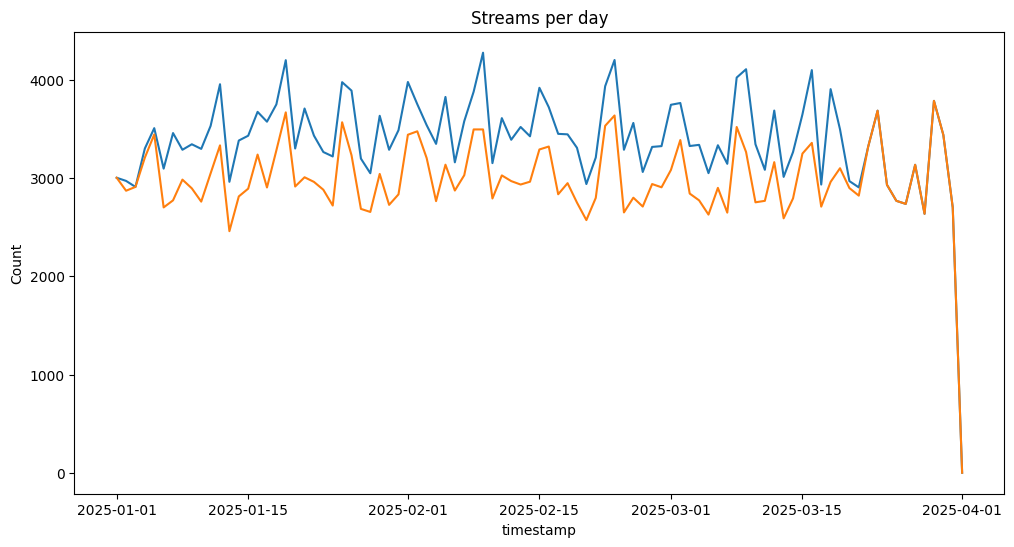

In [49]:
vc = (bot_streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df)['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

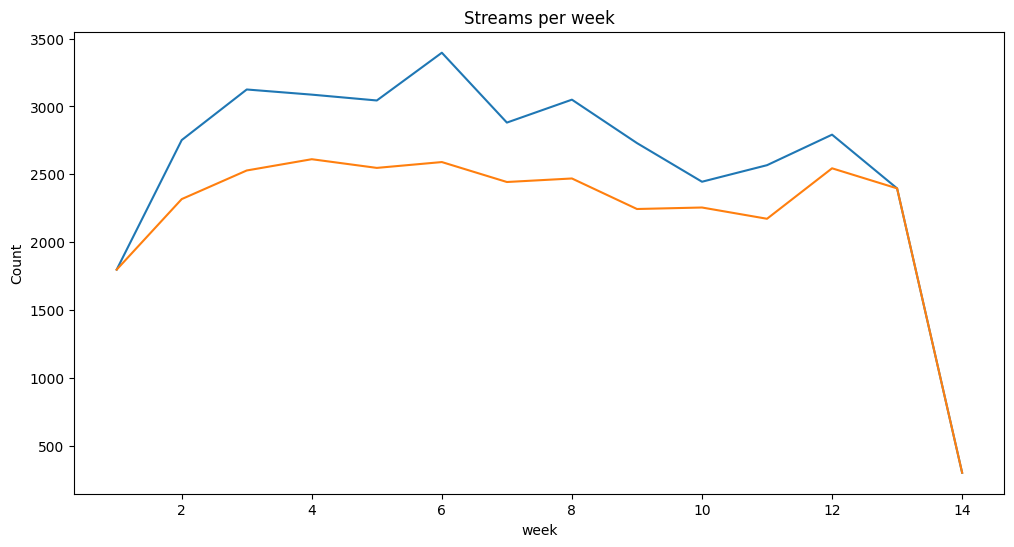

In [50]:
vc = (bot_streams_df[(bot_streams_df['artist_id']=='artist_1') ])['timestamp'].dt.isocalendar().week.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (streams_df[streams_df['artist_id']=='artist_1'])['timestamp'].dt.isocalendar().week.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per week')
plt.show()

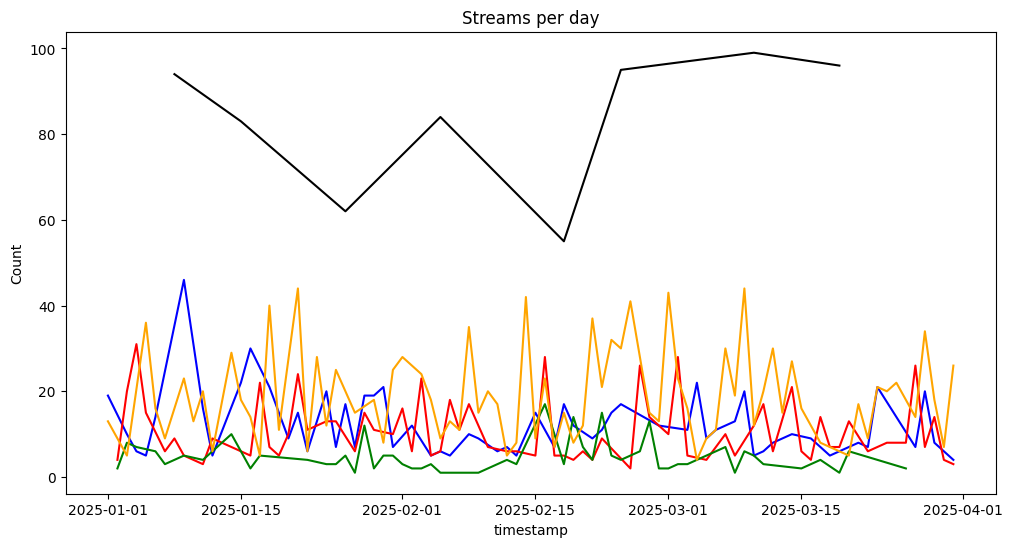

In [51]:
vc = (bot_streams_df[bot_streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='blue')

vc = (bot_streams_df[bot_streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='red')

vc = (bot_streams_df[bot_streams_df['user_id']==3])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='green')

vc = (bot_streams_df[bot_streams_df['user_id']==4])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='orange')

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='black')

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

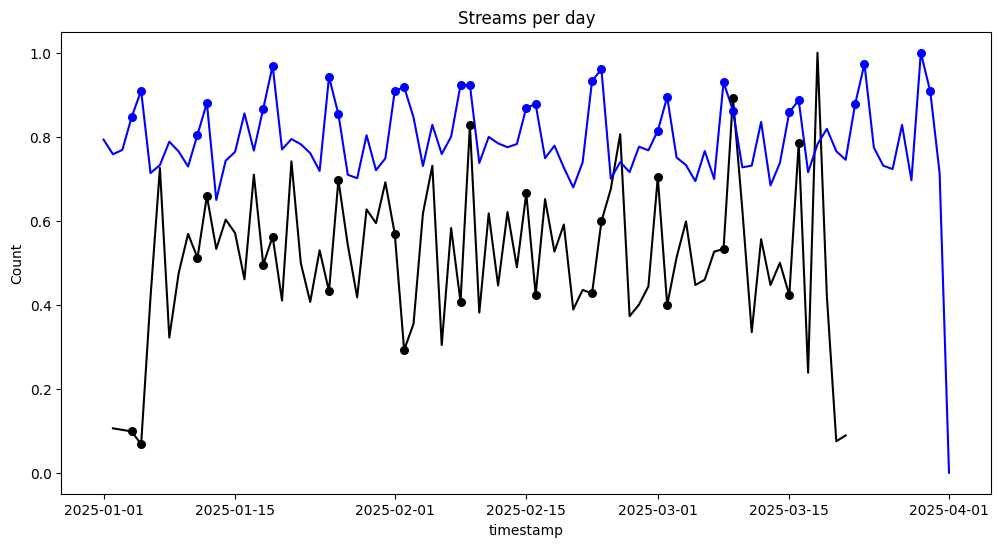

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
vc_bots = (bot_streams_df[bot_streams_df['is_bot']==True])['timestamp'].dt.date.value_counts().sort_index()
vc_bots = vc_bots / vc_bots.max()
vc_bots.plot(kind='line', figsize=(12, 6), color='black')
vc_bots.index = pd.to_datetime(vc_bots.index)
is_weekend = (vc_bots.index.dayofweek == 5) | (vc_bots.index.dayofweek == 6)
weekend_counts = vc_bots[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='black', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['is_bot']==False])['timestamp'].dt.date.value_counts().sort_index()
vc = vc / vc.max()
vc.plot(kind='line', figsize=(12, 6), color='blue')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='blue', s=30, zorder=5)


plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

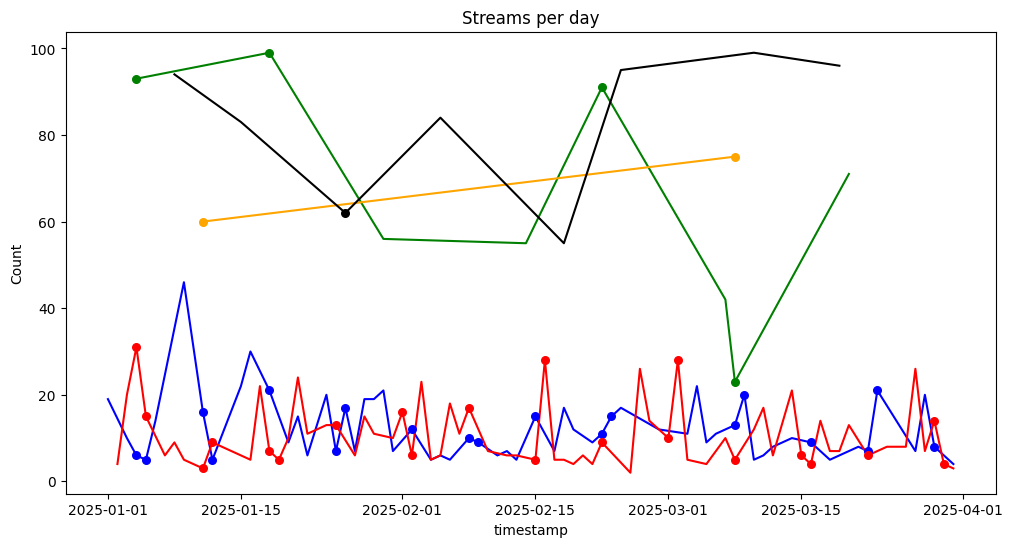

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
vc = (bot_streams_df[bot_streams_df['user_id']==1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='blue')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='blue', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='red')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='red', s=30, zorder=5)


vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()-2])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='green')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='green', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()-1])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6), color='orange')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='orange', s=30, zorder=5)

vc = (bot_streams_df[bot_streams_df['user_id']==bot_streams_df['user_id'].max()])['timestamp'].dt.date.value_counts()
vc = vc.sort_index()
vc.plot(kind='line', color='black')
vc.index = pd.to_datetime(vc.index)
is_weekend = (vc.index.dayofweek == 5) | (vc.index.dayofweek == 6)
weekend_counts = vc[is_weekend]

ax.scatter(weekend_counts.index, weekend_counts.values, color='black', s=30, zorder=5)

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [54]:
joblib.dump(users_df, "users.pkl")
joblib.dump(tracks_df, "tracks.pkl")
joblib.dump(streams_df, "streams.pkl")
joblib.dump(bot_streams_df, "streams_bots.pkl")

['streams_bots.pkl']

In [55]:
"""
joblib.load("users.pkl")
joblib.load("tracks.pkl")
joblib.load("streams.pkl")
joblib.load("streams_bots.pkl")
"""

'\njoblib.load("users.pkl")\njoblib.load("tracks.pkl")\njoblib.load("streams.pkl")\njoblib.load("streams_bots.pkl")\n'

In [56]:
user_day_counts = bot_streams_df.groupby(['user_id', bot_streams_df['timestamp'].dt.date])['track_id'].count().reset_index(name='daily_streams')
user_day_counts["timestamp"] = pd.to_datetime(user_day_counts["timestamp"])

In [57]:
listen_pct_df = bot_streams_df.groupby(['user_id', bot_streams_df['timestamp'].dt.date])[['track_duration_sec','listen_duration_sec']].sum().reset_index()
listen_pct_df['listen_pct'] = listen_pct_df['listen_duration_sec'] / listen_pct_df['track_duration_sec']
listen_pct_df["timestamp"] = pd.to_datetime(listen_pct_df["timestamp"])

In [58]:
user_day_counts=pd.merge(user_day_counts, listen_pct_df, how='inner', on=['user_id','timestamp'])[['user_id','timestamp','daily_streams','listen_pct']]

In [59]:
user_day_counts.head()

,user_id,timestamp,daily_streams,listen_pct
0,1,2025-01-01,19,0.935807
1,1,2025-01-03,10,1.000000
2,1,2025-01-04,6,0.747790
3,1,2025-01-05,5,0.786871
4,1,2025-01-06,14,0.929431


In [60]:
threshold = 60
user_day_counts['high_volume'] = user_day_counts['daily_streams'] > threshold

user_week = user_day_counts.groupby(['user_id', pd.Grouper(key='timestamp', freq='W-MON')])['high_volume'].sum().reset_index()

suspicious = user_week[user_week['high_volume'] >= 4]['user_id'].unique()

In [61]:
suspicious_streamers = user_day_counts[user_day_counts['user_id'].isin(suspicious)]

In [62]:
suspicious_streamers.head()

,user_id,timestamp,daily_streams,listen_pct,high_volume
20157,311,2025-01-07,48,1.0,False
20158,311,2025-01-08,19,1.0,False
20159,311,2025-01-09,75,1.0,True
20160,311,2025-01-12,60,1.0,False
20161,311,2025-01-14,82,1.0,True


In [63]:
user_day_counts['high_volume_suspicious'] = user_day_counts['user_id'].isin(suspicious)

In [64]:
user_day_counts

,user_id,timestamp,daily_streams,listen_pct,high_volume,high_volume_suspicious
0,1,2025-01-01,19,0.935807,False,False
1,1,2025-01-03,10,1.000000,False,False
2,1,2025-01-04,6,0.747790,False,False
3,1,2025-01-05,5,0.786871,False,False
4,1,2025-01-06,14,0.929431,False,False
...,...,...,...,...,...,...
20542,325,2025-02-05,84,1.000000,True,False
20543,325,2025-02-18,55,1.000000,False,False
20544,325,2025-02-24,95,1.000000,True,False
20545,325,2025-03-10,99,1.000000,True,False


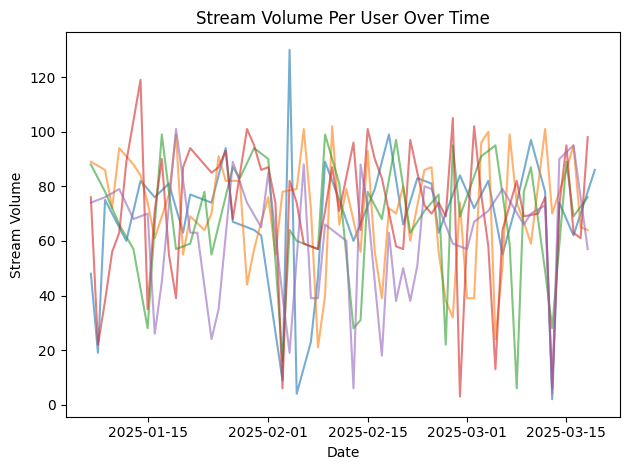

In [65]:
for user_id, group in suspicious_streamers.groupby('user_id'):
    plt.plot(group['timestamp'], group['daily_streams'], label=f'User {user_id}', alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Stream Volume")
plt.title("Stream Volume Per User Over Time")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

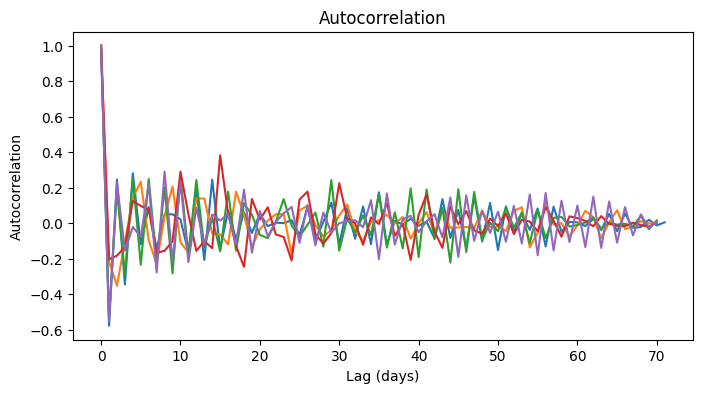

In [66]:
plt.figure(figsize=(8,4))
for user_id in suspicious:
    user_series = (
        user_day_counts[user_day_counts['user_id'] == user_id]
        .set_index('timestamp')
        .asfreq('D', fill_value=0)['daily_streams']
    )

    ac = np.correlate(user_series - user_series.mean(),
                      user_series - user_series.mean(), mode='full')
    ac = ac[ac.size // 2:]  
    ac /= ac[0]
    
    plt.plot(ac)
plt.title(f"Autocorrelation")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()

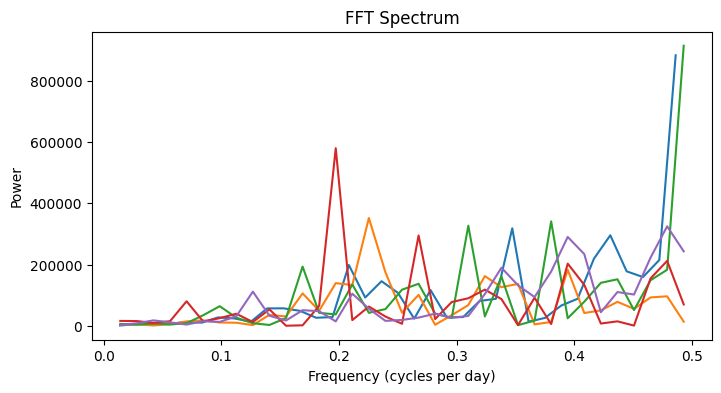

In [67]:
plt.figure(figsize=(8,4))
high_power_users = []
for user_id in suspicious:
    user_series = (
        user_day_counts[user_day_counts['user_id'] == user_id]
        .set_index('timestamp')
        .asfreq('D', fill_value=0)['daily_streams'] 
    )

    values = user_series.values - user_series.mean()
    n = len(values)

    fft_vals = np.fft.fft(values)
    freqs = np.fft.fftfreq(n, d=1)

    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2
    if np.max(power) > 0.2e6:
        high_power_users.append(user_id)


    plt.plot(freqs, power)
plt.title(f"FFT Spectrum")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Power")
plt.show()

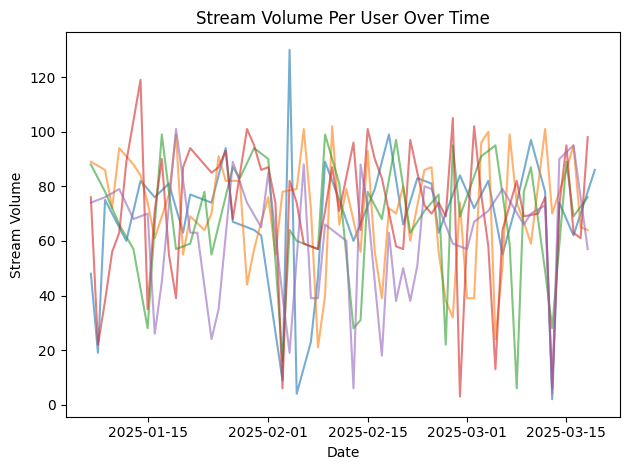

In [68]:
for user_id, group in suspicious_streamers[suspicious_streamers['user_id'].isin(high_power_users)].groupby('user_id'):
    plt.plot(group['timestamp'], group['daily_streams'], label=f'User {user_id}', alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Stream Volume")
plt.title("Stream Volume Per User Over Time")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [69]:
bot_streams_df.head()

,user_id,session_id,timestamp,artist_id,track_id,track_duration_sec,listen_duration_sec,is_bot
0,1,0,2025-01-01 11:33:51.000000000,artist_5,artist_5_track_4,221.135215,221.135215,False
1,1,0,2025-01-01 11:37:32.135215366,artist_5,artist_5_track_24,143.815144,143.815144,False
2,1,0,2025-01-01 11:39:55.950359048,artist_5,artist_5_track_25,186.771027,186.771027,False
3,1,0,2025-01-01 11:43:02.721386533,artist_5,artist_5_track_11,273.485836,67.818156,False
4,1,0,2025-01-01 11:44:10.539542678,artist_5,artist_5_track_6,139.508736,139.508736,False


In [70]:
user_activity = bot_streams_df.groupby("user_id").agg(
    first_stream=("timestamp", "min"),
    last_stream=("timestamp", "max"),
    total_streams=("track_id", "count")
)

In [71]:
user_activity["active_window_days"] = (user_activity["last_stream"] - user_activity["first_stream"]).dt.days + 1
user_activity["streams_per_day"] = user_activity["total_streams"] / user_activity["active_window_days"]

In [72]:
user_day_counts

,user_id,timestamp,daily_streams,listen_pct,high_volume,high_volume_suspicious
0,1,2025-01-01,19,0.935807,False,False
1,1,2025-01-03,10,1.000000,False,False
2,1,2025-01-04,6,0.747790,False,False
3,1,2025-01-05,5,0.786871,False,False
4,1,2025-01-06,14,0.929431,False,False
...,...,...,...,...,...,...
20542,325,2025-02-05,84,1.000000,True,False
20543,325,2025-02-18,55,1.000000,False,False
20544,325,2025-02-24,95,1.000000,True,False
20545,325,2025-03-10,99,1.000000,True,False


In [73]:
threshold = 60
high_days_per_user = (
    user_day_counts[user_day_counts["daily_streams"] > threshold]
    .groupby("user_id")
    .size()
    .reset_index(name="high_stream_days")
)

In [74]:
user_activity = user_activity.merge(
    high_days_per_user, on="user_id", how="left"
).fillna({"high_stream_days": 0})

In [75]:
user_activity['high_stream_rate'] = user_activity['high_stream_days'] / user_activity['active_window_days']

In [76]:
pd.to_pickle(user_activity, "user_activity.pkl")
pd.to_pickle(user_day_counts, "user_day_counts.pkl")

In [77]:
user_day_counts[user_day_counts['user_id']==307]

,user_id,timestamp,daily_streams,listen_pct,high_volume,high_volume_suspicious
20110,307,2025-01-13,70,1.0,True,False


In [ ]:
from sklearn.ensemble import IsolationForest

In [117]:
daily_user_agg = (
    user_day_counts
    .groupby("user_id")
    .agg(
        total_streams=("daily_streams", "sum"),
        avg_listen_pct=("listen_pct", "mean"),
        std_daily_streams=("daily_streams", "std")
    )
    .reset_index()  # important if you want 'user_id' as a column
)

In [118]:
for col in ["total_streams", "avg_listen_pct", "std_daily_streams"]:
    daily_user_agg[col] = pd.to_numeric(daily_user_agg[col], errors='coerce')

In [119]:
numeric_cols = daily_user_agg.select_dtypes(include="number").columns.tolist()
X = daily_user_agg[numeric_cols].drop(columns=['user_id'])

In [120]:
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,  
    random_state=13
)
iso.fit(X)

,n_estimators,100
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,13
,verbose,0
,warm_start,False


In [121]:
daily_user_agg["anomaly_score"] = iso.decision_function(X)   # higher = more normal
daily_user_agg["is_anomaly"] = iso.predict(X)  

In [122]:
daily_user_agg.head()

,user_id,total_streams,avg_listen_pct,std_daily_streams,anomaly_score,is_anomaly
0,1,732,0.911282,7.453358,0.160047,1
1,2,728,0.968659,7.171791,0.189482,1
2,3,247,0.977234,3.725245,0.108413,1
3,4,1467,0.913656,10.710172,0.118371,1
4,5,471,0.972435,5.164241,0.177680,1


In [123]:
sus_users_ml = daily_user_agg[daily_user_agg["is_anomaly"] == -1]

print(f"Flagged {len(sus_users_ml)} users as anomalies")

Flagged 17 users as anomalies


In [140]:
sus_users_ml['user_id']

14      15
72      73
163    164
300    301
301    302
303    304
304    305
306    307
309    310
310    311
311    312
312    313
314    315
316    317
318    319
319    320
323    324
Name: user_id, dtype: int64

In [125]:
correlations = X.corrwith(daily_user_agg["anomaly_score"]).sort_values(key=abs, ascending=False)
print(correlations)

std_daily_streams   -0.693158
total_streams       -0.600335
avg_listen_pct      -0.119873
dtype: float64


In [128]:
user_activity.head()

,user_id,first_stream,last_stream,total_streams,active_window_days,streams_per_day,high_stream_days,high_stream_rate
0,1,2025-01-01 07:39:08,2025-03-31 10:46:19.275785311,732,90,8.133333,0.0,0.0
1,2,2025-01-02 03:25:37,2025-03-31 08:07:29.566376200,728,89,8.179775,0.0,0.0
2,3,2025-01-02 05:25:01,2025-03-26 23:17:45.353778866,247,84,2.940476,0.0,0.0
3,4,2025-01-01 11:15:35,2025-03-31 23:15:51.918423629,1467,90,16.300000,0.0,0.0
4,5,2025-01-01 09:25:20,2025-03-31 19:55:55.000000000,471,90,5.233333,0.0,0.0


In [129]:
numeric_cols = user_activity.select_dtypes(include="number").columns.tolist()
X = user_activity[numeric_cols].drop(columns=['user_id'])

In [130]:
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,  
    random_state=13
)
iso.fit(X)

,n_estimators,100
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,13
,verbose,0
,warm_start,False


In [131]:
iso_user_activity = user_activity.copy()
iso_user_activity["anomaly_score"] = iso.decision_function(X)   # higher = more normal
iso_user_activity["is_anomaly"] = iso.predict(X)  

In [132]:
sus_users_ml = iso_user_activity[iso_user_activity["is_anomaly"] == -1]

print(f"Flagged {len(sus_users_ml)} users as anomalies")

Flagged 17 users as anomalies


In [133]:
correlations = X.corrwith(iso_user_activity["anomaly_score"]).sort_values(key=abs, ascending=False)
print(correlations)

streams_per_day      -0.767268
high_stream_rate     -0.764396
high_stream_days     -0.746327
active_window_days    0.677364
total_streams        -0.606460
dtype: float64


In [139]:
sus_users_ml['user_id']

14      15
72      73
163    164
300    301
301    302
303    304
304    305
306    307
309    310
310    311
311    312
312    313
314    315
316    317
318    319
319    320
323    324
Name: user_id, dtype: int64